In [2]:
import csv
import re
from scipy import sparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.datasets import load_breast_cancer
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer    
from nltk.stem import WordNetLemmatizer 
import spacy
import sys
import wordcloud
from wordcloud import WordCloud, STOPWORDS
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
#Это если будет ругаться на отсутствие каких-то библиотек, и никак по другому их нельзя будет поставить
# import sys  
# !{sys.executable} -m pip install --user sklearn
INDEX_TITLE = 1
INDEX_DESCRIPTION = 2
#установил максимальный размер поля, чтобы не выскакивала ошибка
csv.field_size_limit(sys.maxsize)
#работаем с промаркированным списком issues, полученным 2022-05-17-14-17-51
with open(f"2022-05-17-14-17-51-ALL-LABELED-LIST.csv", newline='', encoding='utf-8') as file_issues:
    all_issues = csv.reader(file_issues)
    all_issues = list(all_issues)
    length = len(all_issues)
    #берем первые 80% issues для обучения и 20% для проверки
    split_index = (length // 10) * 8
    all_issues_train = all_issues[:split_index]
    all_issues_test = all_issues[split_index:]

X_all_texts = []
y_all_labels = []
for issue in all_issues:
    X_all_texts.append(issue[INDEX_TITLE] + ' ' + issue[INDEX_DESCRIPTION])
    if (issue[3] == 'bug'):
        y_all_labels.append(0)
    elif(issue[3] == 'enhancement'): 
        y_all_labels.append(1)
    elif(issue[3] == 'question'):
        y_all_labels.append(2)

print(len(X_all_texts))
print(len(y_all_labels))

2265
2265


In [3]:
def save_predictions_file(filename, values):
  predictions_file = open(filename, "w")
  np.savetxt(predictions_file, values, fmt='%.d')
  predictions_file.close()
def preprocess_issue(issue):
  #в нижний регистр
  issue = issue.lower()
  # цифры все удаляем
  issue = re.sub(r'\d+', ' ', issue)
  # убираем переносы на другую строку, без этого куски кода не уберутся
  issue = issue.replace("\r"," ")
  issue = issue.replace("\n"," ")
  # убираем куски кода и прочие элементы, не влияющие на смысл
  issue = re.sub('(```.+?```)', ' code_block_token ', issue)
  issue = re.sub("###.*\n", ' reproduce_steps_token ', issue)
  issue = re.sub("\!\[.*\n", ' images_and_others_token ', issue)
  issue = re.sub("\<\!\-\-.*\-\-\>", ' standart_comment_token ', issue)
  #убираем двухбуквенные токены - они несут мало смысла.
  issue = re.sub(r"(?u)\b\w\w\b", ' ', issue)
  return issue
def making_comment_words_wordcloud(all_texts):
  comment_words = ''
  # iterate through the csv file
  for val in all_texts:
      
      # typecaste each val to string
      val = str(val)
      val = val.replace(' nan ', ' ')
  
      # split the value
      tokens = val.split()
      
      # Converts each token into lowercase
      for i in range(len(tokens)):
          tokens[i] = tokens[i].lower()    

      comment_words += " ".join(tokens)+" "
  return comment_words

In [4]:
target_names = ['bug', 'enhancement', 'question']

In [5]:
print('Всего issues: ', len(all_issues))

Всего issues:  2265


In [6]:
#векторизация набора данных для обучения
count_vect = CountVectorizer(stop_words='english', min_df=0.01,preprocessor=preprocess_issue)
X_all_texts_counts = count_vect.fit_transform(X_all_texts)
print(X_all_texts_counts.shape)
# print(len(count_vect))
print(count_vect.get_feature_names_out())
with open("DATA_cross_validation/TOKENS.txt", 'w') as f:
  for item in count_vect.get_feature_names_out():
      f.write("%s\n" % str(item))

(2265, 698)
['_no' 'ability' 'able' 'accept' 'access' 'account' 'action' 'actions'
 'actual' 'actually' 'add' 'added' 'adding' 'additional' 'alias' 'allow'
 'allowing' 'allows' 'alt' 'angular' 'api' 'app' 'appear' 'appears'
 'application' 'argument' 'array' 'assert' 'assertion' 'assertions'
 'assets' 'attempt' 'attempting' 'attribute' 'automatically' 'available'
 'bahmutov' 'bar' 'base' 'based' 'baseurl' 'beforeeach' 'behavior'
 'behaviour' 'believe' 'best' 'better' 'binary' 'bit' 'blank' 'blob'
 'block' 'body' 'box' 'branch' 'breaks' 'broken' 'browser' 'browsers'
 'bug' 'build' 'built' 'button' 'cache' 'callback' 'called' 'calling'
 'calls' 'capture' 'case' 'cases' 'cause' 'caused' 'causes' 'certain'
 'change' 'changed' 'changes' 'changing' 'characters' 'check' 'checking'
 'checks' 'child' 'chrome' 'chromium' 'class' 'clear' 'cli' 'click'
 'clicked' 'clicking' 'client' 'clone' 'close' 'cloud' 'code'
 'code_block_token' 'coffee' 'com' 'command' 'commands' 'comment' 'commit'
 'common' '

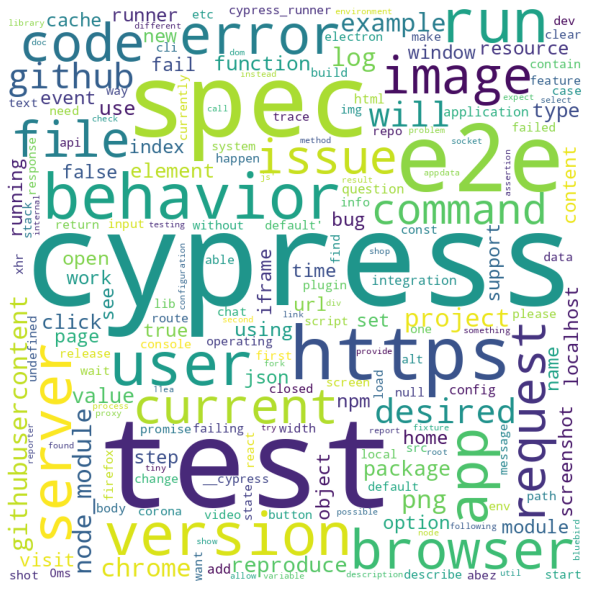

In [7]:
#Здесь генерируются word clouds для всех категорий
df = pd.read_csv(r"2022-05-17-14-17-51-ALL-LABELED-LIST.csv", encoding ="latin-1")

stopwords = set(STOPWORDS)

# print(df.iloc[:, 2])
df["text"] = ' ' + df.iloc[:, 1].astype(str) + ' ' + df.iloc[:, 2].astype(str) + ' '

comment_words = making_comment_words_wordcloud(df["text"])
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_word_length = 3,
                collocation_threshold = 1000000,
                max_words=200,
                min_font_size = 10).generate(comment_words)

# words_with_frequencies = wordcloud.words_
words_with_frequencies = {}
for word in wordcloud.words_:
    add_word = False
    for feature in count_vect.get_feature_names_out():
        if word == feature:
            add_word = True
    if add_word:
        words_with_frequencies.update({word:wordcloud.words_[word]})

words_with_frequencies_items = words_with_frequencies.items()
words_with_frequencies_top_100 = list(words_with_frequencies_items)[:100]        
wordcloud.words_ = words_with_frequencies_top_100 

# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

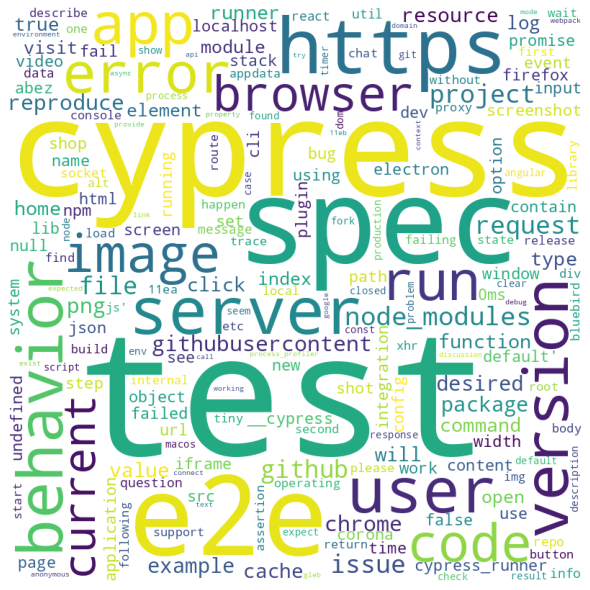

In [8]:
#Здесь генерируются word clouds для категории BUG  так как нужно
df = pd.read_csv(r"data_for_wordclouds/2022-05-17-14-17-51-BUGS-LIST.csv", encoding ="latin-1")

stopwords = set(STOPWORDS)

# print(df.iloc[:, 2])
df["text"] = ' ' + df.iloc[:, 1].astype(str) + ' ' + df.iloc[:, 2].astype(str) + ' '

comment_words = making_comment_words_wordcloud(df["text"])
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_word_length = 3,
                collocation_threshold = 1000000,
                max_words=200,
                min_font_size = 10).generate(comment_words)

# words_with_frequencies = wordcloud.words_
words_with_frequencies = {}
for word in wordcloud.words_:
    add_word = False
    for feature in count_vect.get_feature_names_out():
        if word == feature:
            add_word = True
    if add_word:
        words_with_frequencies.update({word:wordcloud.words_[word]})

words_with_frequencies_items = words_with_frequencies.items()
words_with_frequencies_top_100 = list(words_with_frequencies_items)[:100]        
wordcloud.words_ = words_with_frequencies_top_100

# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

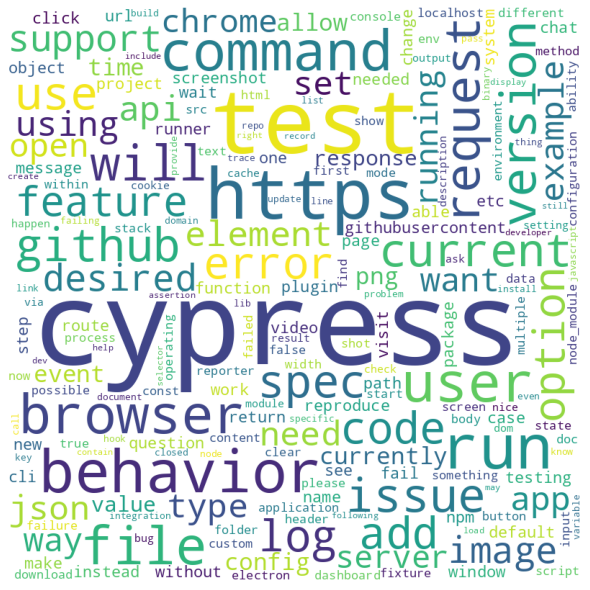

In [9]:
#Здесь генерируются word clouds для категории ENHANCEMENTS  так как нужно
df = pd.read_csv(r"data_for_wordclouds/2022-05-17-14-17-51-ENHANCEMENTS-LIST.csv", encoding ="latin-1")
 
stopwords = set(STOPWORDS)

# print(df.iloc[:, 2])
df["text"] = ' ' + df.iloc[:, 1].astype(str) + ' ' + df.iloc[:, 2].astype(str) + ' '

comment_words = making_comment_words_wordcloud(df["text"])
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_word_length = 3,
                collocation_threshold = 1000000,
                max_words=200,
                min_font_size = 10).generate(comment_words)

# words_with_frequencies = wordcloud.words_
words_with_frequencies = {}
for word in wordcloud.words_:
    add_word = False
    for feature in count_vect.get_feature_names_out():
        if word == feature:
            add_word = True
    if add_word:
        words_with_frequencies.update({word:wordcloud.words_[word]})

words_with_frequencies_items = words_with_frequencies.items()
words_with_frequencies_top_100 = list(words_with_frequencies_items)[:100]        
wordcloud.words_ = words_with_frequencies_top_100

# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

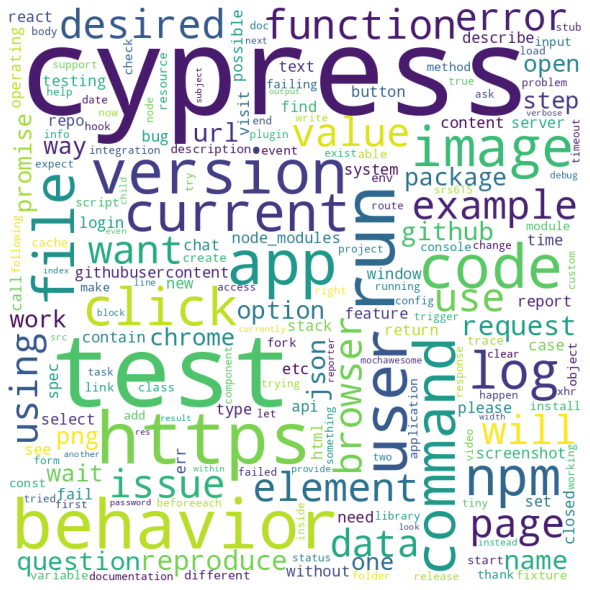

In [10]:
#Здесь генерируются word clouds для категории QUESTIONS  так как нужно
df = pd.read_csv(r"data_for_wordclouds/2022-05-17-14-17-51-QUESTIONS-LIST.csv", encoding ="latin-1")
 
stopwords = set(STOPWORDS)

# print(df.iloc[:, 2])
df["text"] = ' ' + df.iloc[:, 1].astype(str) + ' ' + df.iloc[:, 2].astype(str) + ' '

comment_words = making_comment_words_wordcloud(df["text"])
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_word_length = 3,
                collocation_threshold = 1000000,
                max_words=200,
                min_font_size = 10).generate(comment_words)

# words_with_frequencies = wordcloud.words_
words_with_frequencies = {}
for word in wordcloud.words_:
    add_word = False
    for feature in count_vect.get_feature_names_out():
        if word == feature:
            add_word = True
    if add_word:
        words_with_frequencies.update({word:wordcloud.words_[word]})

words_with_frequencies_items = words_with_frequencies.items()
words_with_frequencies_top_100 = list(words_with_frequencies_items)[:100]        
wordcloud.words_ = words_with_frequencies_top_100

# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [11]:
#узнать индекс токена в словаре
indexToken = count_vect.vocabulary_.get('standart_comment_token')
print(indexToken)

581


In [12]:
#получаем набор данных для обучения, взвешенных по алгоритму tfidf
tfidf_transformer = TfidfTransformer()
X_all_texts_tfidf = tfidf_transformer.fit_transform(X_all_texts_counts)
print(X_all_texts_tfidf.shape)
# print(tfidf_transformer.get_feature_names_out())

(2265, 698)


In [13]:
#Implementing cross validation
 
k = 5
kf = KFold(n_splits=k, random_state=None)
model = SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=5, tol=None)
 
acc_score = []

X_all_texts_tfidf_dataframe = pd.DataFrame(X_all_texts_tfidf.toarray())
y_all_labels_dataframe = pd.DataFrame(y_all_labels)

predicted = pd.Series([], dtype='float64')
y_test_all = pd.Series([], dtype='float64')

X_all_texts_tfidf_csr = sparse.csr_matrix(X_all_texts_tfidf_dataframe)

X_all_texts_tfidf_csr.maxprint = X_all_texts_tfidf_csr.count_nonzero()
with open("DATA_cross_validation/X_all_csr.txt","w") as file:
    file.write(str(X_all_texts_tfidf_csr)) 
    file.close()

with open("DATA_cross_validation/y_all.txt", 'w') as f:
    for item in y_all_labels:
        f.write("%s\n" % str(item))
i = 1
for train_index , test_index in kf.split(X_all_texts_tfidf_dataframe):
    X_train , X_test = X_all_texts_tfidf_dataframe.iloc[train_index,:],X_all_texts_tfidf_dataframe.iloc[test_index,:]
    y_train , y_test = y_all_labels_dataframe.iloc[train_index,0] , y_all_labels_dataframe.iloc[test_index,0]
    # print(f"TRAIN {i}:", train_index, f"TEST {i}:", test_index)
    with open(f"DATA_cross_validation/test_indexes_fold{i}.txt", 'w') as f:
        f.write(str(test_index))
        f.close()
    X_train_csr = sparse.csr_matrix(X_train)
    X_test_csr = sparse.csr_matrix(X_test)
    model.fit(X_train_csr,y_train)
    pred_values = model.predict(X_test_csr)

    pred_values = pd.Series(pred_values)

    predicted = pd.concat([predicted, pred_values], ignore_index=True)
    y_test_all = pd.concat([y_test_all, y_test], ignore_index=True)
    i = i + 1

print("Результаты метода SVM:")
print(metrics.classification_report(y_test_all, predicted,
target_names=target_names))

with open("DATA_cross_validation/SVM_predicted.txt", 'w') as f:
    for item in predicted:
        f.write("%s\n" % str(item))

with open("DATA_cross_validation/RESULTS_cross_validation.txt", 'w') as f:
    f.write('SVM_results\n\n')
    f.write(metrics.classification_report(y_test_all, predicted,
target_names=target_names))
    f.write('\n\n')



Результаты метода SVM:
              precision    recall  f1-score   support

         bug       0.74      0.91      0.81      1085
 enhancement       0.76      0.75      0.75       869
    question       0.55      0.13      0.21       311

    accuracy                           0.74      2265
   macro avg       0.68      0.59      0.59      2265
weighted avg       0.72      0.74      0.71      2265



In [14]:
#Implementing cross validation
 
k = 5
kf = KFold(n_splits=k, random_state=None)
model = MultinomialNB()
 
acc_score = []

X_all_texts_tfidf_dataframe = pd.DataFrame(X_all_texts_tfidf.toarray())
y_all_labels_dataframe = pd.DataFrame(y_all_labels)

predicted = pd.Series([], dtype='float64')
y_test_all = pd.Series([], dtype='float64')

for train_index , test_index in kf.split(X_all_texts_tfidf_dataframe):
    X_train , X_test = X_all_texts_tfidf_dataframe.iloc[train_index,:],X_all_texts_tfidf_dataframe.iloc[test_index,:]
    y_train , y_test = y_all_labels_dataframe.iloc[train_index,0] , y_all_labels_dataframe.iloc[test_index,0]
    X_train_csr = sparse.csr_matrix(X_train)
    X_test_csr = sparse.csr_matrix(X_test)
    model.fit(X_train_csr,y_train)
    pred_values = model.predict(X_test_csr)

    pred_values = pd.Series(pred_values)

    predicted = pd.concat([predicted, pred_values], ignore_index=True)
    y_test_all = pd.concat([y_test_all, y_test], ignore_index=True)

print("Результаты метода Naive Bayes:")
print(metrics.classification_report(y_test_all, predicted,
target_names=target_names))

with open("DATA_cross_validation/NB_predicted.txt", 'w') as f:
    for item in predicted:
        f.write("%s\n" % str(item))

with open("DATA_cross_validation/RESULTS_cross_validation.txt", 'a') as f:
    f.write('Naive_Bayes_results\n\n')
    f.write(metrics.classification_report(y_test_all, predicted,
target_names=target_names))
    f.write('\n\n')

Результаты метода Naive Bayes:
              precision    recall  f1-score   support

         bug       0.71      0.91      0.80      1085
 enhancement       0.74      0.73      0.73       869
    question       0.55      0.04      0.07       311

    accuracy                           0.72      2265
   macro avg       0.67      0.56      0.54      2265
weighted avg       0.70      0.72      0.67      2265



In [15]:
#Implementing cross validation
 
k = 5
kf = KFold(n_splits=k, random_state=None)
model = KNeighborsClassifier(n_neighbors=5)
 
acc_score = []

X_all_texts_tfidf_dataframe = pd.DataFrame(X_all_texts_tfidf.toarray())
y_all_labels_dataframe = pd.DataFrame(y_all_labels)

predicted = pd.Series([], dtype='float64')
y_test_all = pd.Series([], dtype='float64')

for train_index , test_index in kf.split(X_all_texts_tfidf_dataframe):
    X_train , X_test = X_all_texts_tfidf_dataframe.iloc[train_index,:],X_all_texts_tfidf_dataframe.iloc[test_index,:]
    y_train , y_test = y_all_labels_dataframe.iloc[train_index,0] , y_all_labels_dataframe.iloc[test_index,0]
    X_train_csr = sparse.csr_matrix(X_train)
    X_test_csr = sparse.csr_matrix(X_test)
    model.fit(X_train_csr,y_train)
    pred_values = model.predict(X_test_csr)

    pred_values = pd.Series(pred_values)

    predicted = pd.concat([predicted, pred_values], ignore_index=True)
    y_test_all = pd.concat([y_test_all, y_test], ignore_index=True)

print("Результаты метода KNN:")
print(metrics.classification_report(y_test_all, predicted,
target_names=target_names))

with open("DATA_cross_validation/KNN_predicted.txt", 'w') as f:
    for item in predicted:
        f.write("%s\n" % str(item))

with open("DATA_cross_validation/RESULTS_cross_validation.txt", 'a') as f:
    f.write('KNN_results\n\n')
    f.write(metrics.classification_report(y_test_all, predicted,
target_names=target_names))
    f.write('\n\n')

Результаты метода KNN:
              precision    recall  f1-score   support

         bug       0.59      0.79      0.67      1085
 enhancement       0.58      0.50      0.54       869
    question       0.30      0.07      0.11       311

    accuracy                           0.58      2265
   macro avg       0.49      0.45      0.44      2265
weighted avg       0.55      0.58      0.54      2265



In [16]:
#Implementing cross validation
 
k = 5
kf = KFold(n_splits=k, random_state=None)
model = DecisionTreeClassifier()
 
acc_score = []

X_all_texts_tfidf_dataframe = pd.DataFrame(X_all_texts_tfidf.toarray())
y_all_labels_dataframe = pd.DataFrame(y_all_labels)

predicted = pd.Series([], dtype='float64')
y_test_all = pd.Series([], dtype='float64')

for train_index , test_index in kf.split(X_all_texts_tfidf_dataframe):
    X_train , X_test = X_all_texts_tfidf_dataframe.iloc[train_index,:],X_all_texts_tfidf_dataframe.iloc[test_index,:]
    y_train , y_test = y_all_labels_dataframe.iloc[train_index,0] , y_all_labels_dataframe.iloc[test_index,0]
    X_train_csr = sparse.csr_matrix(X_train)
    X_test_csr = sparse.csr_matrix(X_test)
    model.fit(X_train_csr,y_train)
    pred_values = model.predict(X_test_csr)

    pred_values = pd.Series(pred_values)

    predicted = pd.concat([predicted, pred_values], ignore_index=True)
    y_test_all = pd.concat([y_test_all, y_test], ignore_index=True)

print("Результаты метода Decision Tree:")
print(metrics.classification_report(y_test_all, predicted,
target_names=target_names))

with open("DATA_cross_validation/DT_predicted.txt", 'w') as f:
    for item in predicted:
        f.write("%s\n" % str(item))

with open("DATA_cross_validation/RESULTS_cross_validation.txt", 'a') as f:
    f.write('DT_results\n\n')
    f.write(metrics.classification_report(y_test_all, predicted,
target_names=target_names))
    f.write('\n\n')

Результаты метода Decision Tree:
              precision    recall  f1-score   support

         bug       0.69      0.69      0.69      1085
 enhancement       0.60      0.61      0.61       869
    question       0.20      0.20      0.20       311

    accuracy                           0.59      2265
   macro avg       0.50      0.50      0.50      2265
weighted avg       0.59      0.59      0.59      2265



In [17]:
#Implementing cross validation
 
k = 5
kf = KFold(n_splits=k, random_state=None)
model = RandomForestClassifier()
 
acc_score = []

X_all_texts_tfidf_dataframe = pd.DataFrame(X_all_texts_tfidf.toarray())
y_all_labels_dataframe = pd.DataFrame(y_all_labels)

predicted = pd.Series([], dtype='float64')
y_test_all = pd.Series([], dtype='float64')

for train_index , test_index in kf.split(X_all_texts_tfidf_dataframe):
    X_train , X_test = X_all_texts_tfidf_dataframe.iloc[train_index,:],X_all_texts_tfidf_dataframe.iloc[test_index,:]
    y_train , y_test = y_all_labels_dataframe.iloc[train_index,0] , y_all_labels_dataframe.iloc[test_index,0]
    X_train_csr = sparse.csr_matrix(X_train)
    X_test_csr = sparse.csr_matrix(X_test)
    model.fit(X_train_csr,y_train)
    pred_values = model.predict(X_test_csr)

    pred_values = pd.Series(pred_values)

    predicted = pd.concat([predicted, pred_values], ignore_index=True)
    y_test_all = pd.concat([y_test_all, y_test], ignore_index=True)

print("Результаты метода Random Forest:")
print(metrics.classification_report(y_test_all, predicted,
target_names=target_names))

with open("DATA_cross_validation/RF_predicted.txt", 'w') as f:
    for item in predicted:
        f.write("%s\n" % str(item))

with open("DATA_cross_validation/RESULTS_cross_validation.txt", 'a') as f:
    f.write('RF_results\n\n')
    f.write(metrics.classification_report(y_test_all, predicted,
target_names=target_names))
    f.write('\n\n')

Результаты метода Random Forest:
              precision    recall  f1-score   support

         bug       0.73      0.88      0.80      1085
 enhancement       0.72      0.74      0.73       869
    question       0.38      0.07      0.11       311

    accuracy                           0.71      2265
   macro avg       0.61      0.56      0.55      2265
weighted avg       0.68      0.71      0.68      2265



In [22]:
#Implementing cross validation
 
k = 5
kf = KFold(n_splits=k, random_state=None)
model = LogisticRegression()
 
acc_score = []

X_all_texts_tfidf_dataframe = pd.DataFrame(X_all_texts_tfidf.toarray())
y_all_labels_dataframe = pd.DataFrame(y_all_labels)

predicted = pd.Series([], dtype='float64')
y_test_all = pd.Series([], dtype='float64')

for train_index , test_index in kf.split(X_all_texts_tfidf_dataframe):
    X_train , X_test = X_all_texts_tfidf_dataframe.iloc[train_index,:],X_all_texts_tfidf_dataframe.iloc[test_index,:]
    y_train , y_test = y_all_labels_dataframe.iloc[train_index,0] , y_all_labels_dataframe.iloc[test_index,0]
    X_train_csr = sparse.csr_matrix(X_train)
    X_test_csr = sparse.csr_matrix(X_test)
    model.fit(X_train_csr,y_train)
    pred_values = model.predict(X_test_csr)

    pred_values = pd.Series(pred_values)

    predicted = pd.concat([predicted, pred_values], ignore_index=True)
    y_test_all = pd.concat([y_test_all, y_test], ignore_index=True)

print("Результаты метода Logistic Regression:")
print(metrics.classification_report(y_test_all, predicted,
target_names=target_names))

with open("DATA_cross_validation/LogReg_predicted.txt", 'w') as f:
    for item in predicted:
        f.write("%s\n" % str(item))

with open("DATA_cross_validation/RESULTS_cross_validation.txt", 'a') as f:
    f.write('LogisticRegression_results\n\n')
    f.write(metrics.classification_report(y_test_all, predicted,
target_names=target_names))
    f.write('\n\n')
    f.close()

  (0, 21)	0.09707988907445936
  (0, 45)	0.17853737307905243
  (0, 99)	0.11763586488694652
  (0, 109)	0.1314867906291265
  (0, 113)	0.4053044876520181
  (0, 138)	0.2154282570722742
  (0, 219)	0.11168297838643337
  (0, 227)	0.18799683633161193
  (0, 254)	0.16251601791893405
  (0, 260)	0.32002604203258317
  (0, 276)	0.1388020050668418
  (0, 292)	0.11226834436151893
  (0, 300)	0.17211043794937056
  (0, 327)	0.21679984049578377
  (0, 335)	0.13447096422745816
  (0, 356)	0.1693114268079621
  (0, 363)	0.44749782479641864
  (0, 366)	0.15222367502985532
  (0, 402)	0.13607040147678653
  (0, 430)	0.1374080344224654
  (0, 442)	0.16001302101629158
  (0, 527)	0.07775786200158502
  (0, 531)	0.158688767986357
  (0, 549)	0.1544312869796908
  (0, 596)	0.17115089508076523
  :	:
  (1809, 592)	0.2258597722649358
  (1809, 615)	0.4697677031535077
  (1809, 648)	0.1835266833002912
  (1810, 14)	0.2079939727431176
  (1810, 73)	0.37717118217520407
  (1810, 97)	0.07333482914322935
  (1810, 138)	0.05374866821685231
